In [1]:
%cd /content/drive/My\ Drive/projects/denoising_autoencoders/

/content/drive/My Drive/projects/denoising_autoencoders


In [195]:
!git log

Unstaged changes after reset:
D	Proposal_draft_v0.pdf
D	image_denoising_autoencoders.pdf


In [3]:
%load_ext tensorboard

import matplotlib
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
from PIL import Image, ImageDraw

from datafeed.mnist import get_data
from mdls.cae1 import ConvAutoencoder

from packaging import version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow version:  2.2.0


train images: 60000
test images: 10000


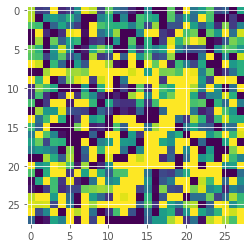

In [27]:
ds_train, ds_test = get_data()
train_noise = np.random.normal(loc=0.5, scale=0.5, size=ds_train.shape)
test_noise = np.random.normal(loc=0.5, scale=0.5, size=ds_test.shape)
ds_train_noisy = np.clip(ds_train + train_noise, 0, 1)
ds_test_noisy = np.clip(ds_test + test_noise, 0, 1)
plt.imshow(ds_test[0].reshape(28, 28))
plt.imshow(ds_test_noisy[0].reshape(28, 28))
plt.show()

In [28]:
!rm -rf ./logs/ 

[INFO] building autoencoder...
Epoch 1/25
938/938 [==============================] - 124s 132ms/step - loss: 0.0324 - accuracy: 0.8018 - val_loss: 0.0199 - val_accuracy: 0.8087
Epoch 2/25
938/938 [==============================] - 123s 132ms/step - loss: 0.0193 - accuracy: 0.8103 - val_loss: 0.0197 - val_accuracy: 0.8108
Epoch 3/25
938/938 [==============================] - 123s 131ms/step - loss: 0.0180 - accuracy: 0.8108 - val_loss: 0.0174 - val_accuracy: 0.8095
Epoch 4/25
938/938 [==============================] - 124s 132ms/step - loss: 0.0173 - accuracy: 0.8111 - val_loss: 0.0172 - val_accuracy: 0.8091
Epoch 5/25
938/938 [==============================] - 123s 131ms/step - loss: 0.0169 - accuracy: 0.8112 - val_loss: 0.0170 - val_accuracy: 0.8097
Epoch 6/25
938/938 [==============================] - 123s 132ms/step - loss: 0.0166 - accuracy: 0.8114 - val_loss: 0.0168 - val_accuracy: 0.8103
Epoch 7/25
938/938 [==============================] - 125s 133ms/step - loss: 0.0164 - accura

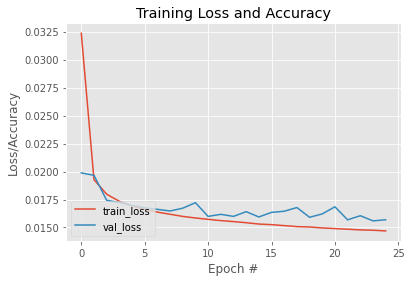

In [30]:
EPOCHS = 25
BS = 64

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = 'logs/checkpoints/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt,metrics='accuracy')

H = autoencoder.fit(
	ds_train_noisy, ds_train,
	validation_data=(ds_test_noisy, ds_test),
	epochs=EPOCHS,
	batch_size=BS,
	callbacks=[tensorboard_callback, model_checkpoint_callback])

In [44]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 32)        1846

In [145]:
from scipy.interpolate import interp1d
A = np.asarray([ 13.392838  ,  11.359178  ,  -5.105344  ,  -4.529157  ,
          9.666895  ,  -3.76251   ,  -1.9859306 , -28.298601  ,
         -7.507314  ,  44.852806  ,  16.021845  , -12.073166  ,
         -6.742583  ,  -4.887852  ,  10.3465185 , -24.607094  ])
B = np.asarray([-25.22879  ,  17.797604 , -12.311653 , -15.772889 , -16.094666 ,
        12.181442 ,   4.984578 ,  23.822454 ,  -5.419549 , -39.80802  ,
        -1.6579286, -26.272871 ,   0.5918721,  19.685024 , -44.57174  ,
        10.518916 ])
C = np.asarray([ -7.5432973 ,  33.123196  ,  -0.53048575,  -0.87037593,
         2.9526322 ,  12.78998   ,  -8.096527  ,   0.7460526 ,
       -15.989921  ,   6.067787  , -15.741248  ,  -7.645519  ,
        -3.4988408 ,   7.427711  ,   3.0705411 , -11.191     ])

space = np.linspace(0,1,100)
grid_z1 = interp1d([0, .33, .66, 1], [A, B, C, A],axis=0)(space)

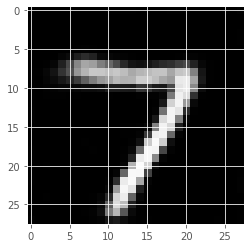

In [146]:
out = decoder.predict([grid_z1])
imgs = []
for item in out:
    imgs.append(Image.fromarray(item.reshape(28,28)*255))
plt.imshow(imgs[0])
imgs[0].save('7to5.gif',save_all=True, append_images=imgs[1:], loop=0)

[INFO] making predictions...


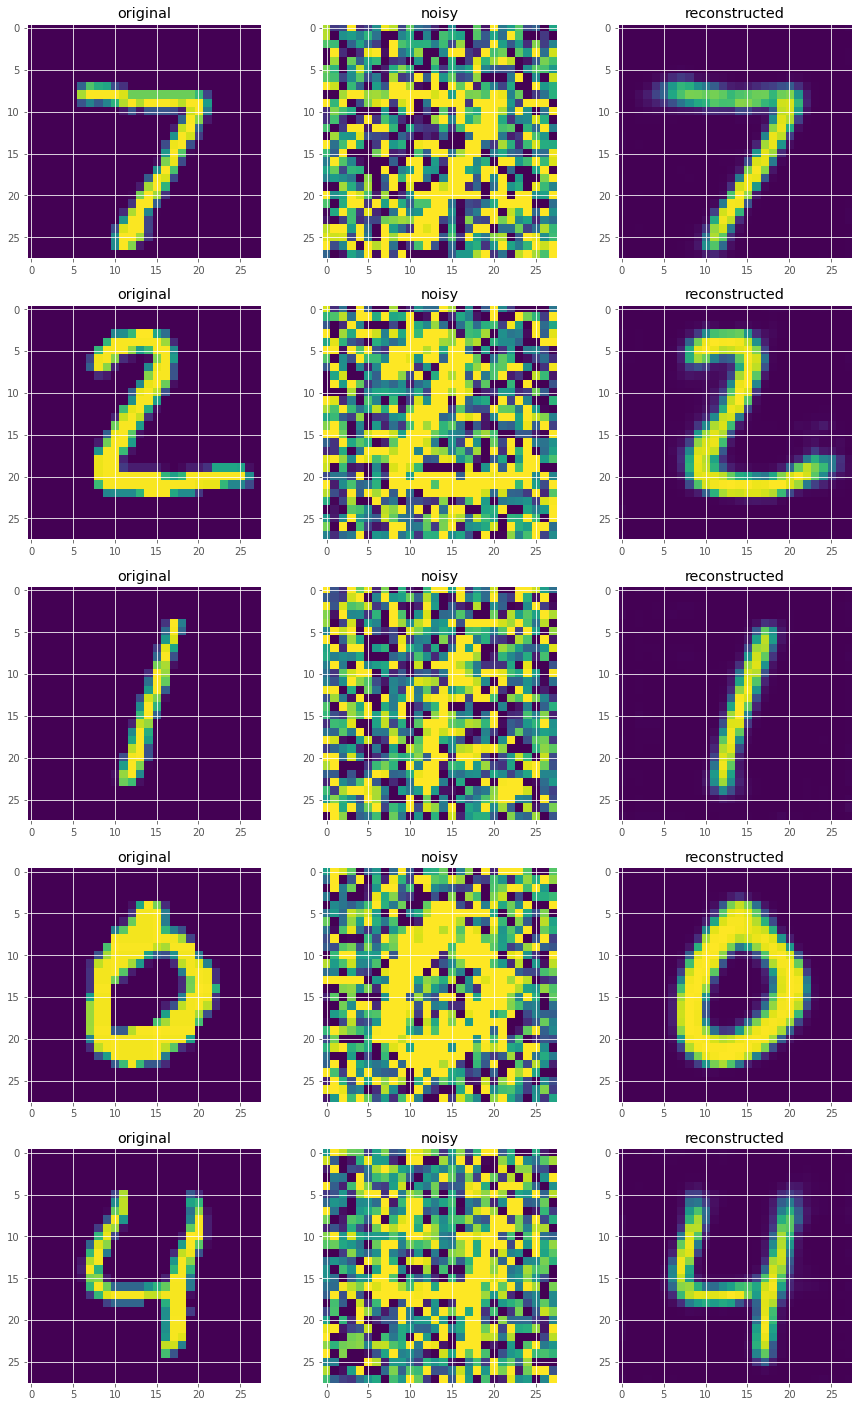

In [162]:
print("[INFO] making predictions...")
l=5
decoded = autoencoder.predict(ds_test_noisy[0:l])
outputs = None

fig, axs = plt.subplots(l, 3, constrained_layout=False)
fig.set_figheight(5*l)
fig.set_figwidth(15)
for i in range(0, l):
    original = ds_test[i]
    noisy = ds_test_noisy[i]
    recon = decoded[i]

    axs[i][0].set_title('original')
    axs[i][0].imshow(original.reshape(28,28))
    axs[i][1].set_title('noisy')
    axs[i][1].imshow(noisy.reshape(28,28))
    axs[i][2].set_title('reconstructed')
    axs[i][2].imshow(recon.reshape(28,28))

fig.savefig('plot.png')

In [ ]:
%tensorboard --logdir logs